# Glassdoor_reviews data analysis to classify a company as good or bad from the public reviews

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import random
import re
import string
import nltk
from collections import defaultdict
from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# Prevent future/deprecation warnings from showing in output
import warnings
warnings.filterwarnings(action='ignore')

data = pd.read_csv('C:/Users/Hemang/Desktop/Data Science/Project/employee_reviews.csv',index_col=0)
df = pd.DataFrame(data)
df.head(5)

,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5,4,5,5,4,5,0,https://www.glassdoor.com/Reviews/Google-Revie...
2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4,2,3,3,5,3,2094,https://www.glassdoor.com/Reviews/Google-Revie...
3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5,5,4,5,5,4,949,https://www.glassdoor.com/Reviews/Google-Revie...
4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5,2,5,5,4,5,498,https://www.glassdoor.com/Reviews/Google-Revie...
5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5,5,5,5,5,5,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [2]:
# Replace 'none' with NaN
df.replace(to_replace = 'none', value = np.nan, inplace = True)
df['dates'].replace('None', np.nan, inplace=True)
df=df.dropna(subset=['dates'])
df.isnull().sum()


company                           0
location                      25085
dates                             0
job-title                         0
summary                         129
pros                              0
cons                              1
advice-to-mgmt                29460
overall-ratings                   0
work-balance-stars             7160
culture-values-stars          13546
carrer-opportunities-stars     7108
comp-benefit-stars             7161
senior-mangemnet-stars         7775
helpful-count                     0
link                              0
dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67528 entries, 1 to 67529
Data columns (total 16 columns):
company                       67528 non-null object
location                      42443 non-null object
dates                         67528 non-null object
job-title                     67528 non-null object
summary                       67399 non-null object
pros                          67528 non-null object
cons                          67527 non-null object
advice-to-mgmt                38068 non-null object
overall-ratings               67528 non-null int64
work-balance-stars            60368 non-null object
culture-values-stars          53982 non-null object
carrer-opportunities-stars    60420 non-null object
comp-benefit-stars            60367 non-null object
senior-mangemnet-stars        59753 non-null object
helpful-count                 67528 non-null int64
link                          67528 non-null object
dtypes: int64(2), object(14)
memory usage: 8.8+ MB


In [4]:
# convert object to float datatype
df['work-balance-stars'] = df['work-balance-stars'].astype(dtype=np.float64)
df['culture-values-stars'] = df['culture-values-stars'].astype(dtype=np.float64)
df['carrer-opportunities-stars'] = df['carrer-opportunities-stars'].astype(dtype=np.float64)
df['comp-benefit-stars'] = df['comp-benefit-stars'].astype(dtype=np.float64)
df['senior-mangemnet-stars'] = df['senior-mangemnet-stars'].astype(dtype=np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67528 entries, 1 to 67529
Data columns (total 16 columns):
company                       67528 non-null object
location                      42443 non-null object
dates                         67528 non-null object
job-title                     67528 non-null object
summary                       67399 non-null object
pros                          67528 non-null object
cons                          67527 non-null object
advice-to-mgmt                38068 non-null object
overall-ratings               67528 non-null int64
work-balance-stars            60368 non-null float64
culture-values-stars          53982 non-null float64
carrer-opportunities-stars    60420 non-null float64
comp-benefit-stars            60367 non-null float64
senior-mangemnet-stars        59753 non-null float64
helpful-count                 67528 non-null int64
link                          67528 non-null object
dtypes: float64(5), int64(2), object(9)
memory usage: 8.

In [5]:
## GROUPING BY COMPANY AND CALCULATING AVERAGE OF EACH PARAMETER- BEFORE IMPUTING##
group_by_df_before_imputing=df[['company','work-balance-stars','culture-values-stars','carrer-opportunities-stars','comp-benefit-stars','senior-mangemnet-stars']].groupby('company').mean()
df_avg=group_by_df_before_imputing.reset_index()

In [6]:
### IMPUTING NaN VALUES WITH THE MEAN OF THE VALUES OF RATINGS (COMPANY WISE) ###
df.loc[df['work-balance-stars'].isnull(), 'work-balance-stars'] = df.groupby('company')['work-balance-stars'].transform('mean')
df.loc[df['culture-values-stars'].isnull(), 'culture-values-stars'] = df.groupby('company')['culture-values-stars'].transform('mean')
df.loc[df['carrer-opportunities-stars'].isnull(), 'carrer-opportunities-stars'] = df.groupby('company')['carrer-opportunities-stars'].transform('mean')
df.loc[df['comp-benefit-stars'].isnull(), 'comp-benefit-stars'] = df.groupby('company')['comp-benefit-stars'].transform('mean')
df.loc[df['senior-mangemnet-stars'].isnull(), 'senior-mangemnet-stars'] = df.groupby('company')['senior-mangemnet-stars'].transform('mean')
df.isnull().sum()

company                           0
location                      25085
dates                             0
job-title                         0
summary                         129
pros                              0
cons                              1
advice-to-mgmt                29460
overall-ratings                   0
work-balance-stars                0
culture-values-stars              0
carrer-opportunities-stars        0
comp-benefit-stars                0
senior-mangemnet-stars            0
helpful-count                     0
link                              0
dtype: int64

In [7]:
## WE HAD 2 ROWS WITH DATE AS JAN 0, 0000 AND 3 DATES WITH DATE AS NOV 0, 0000 ##
## SO DELETED THOSE 5 ROWS BECAUSE WE CANNOT CONVERT THOSE VALUES TO DATES SINCE THOSE ARE NOT VALID DATES ##

df.drop(df[df.dates==' Jan 0, 0000'].index,inplace=True)
df.drop(df[df.dates==' Nov 0, 0000'].index,inplace=True)
rows_where_date_is_zero=df['dates'].str.contains(' Nov 0, 0000')


In [8]:
# Change date from string to datetime format

df['dates'] = df['dates'].apply(lambda x: dt.datetime.strptime(x,' %b %d, %Y'))
print(type(df['dates'].iloc[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
df_word = df
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 67525 entries, 1 to 67529
Data columns (total 16 columns):
company                       67525 non-null object
location                      42440 non-null object
dates                         67525 non-null datetime64[ns]
job-title                     67525 non-null object
summary                       67396 non-null object
pros                          67525 non-null object
cons                          67524 non-null object
advice-to-mgmt                38068 non-null object
overall-ratings               67525 non-null int64
work-balance-stars            67525 non-null float64
culture-values-stars          67525 non-null float64
carrer-opportunities-stars    67525 non-null float64
comp-benefit-stars            67525 non-null float64
senior-mangemnet-stars        67525 non-null float64
helpful-count                 67525 non-null int64
link                          67525 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2),

# Data Visualization

<h3>Which company has the most Reviews?</h3>

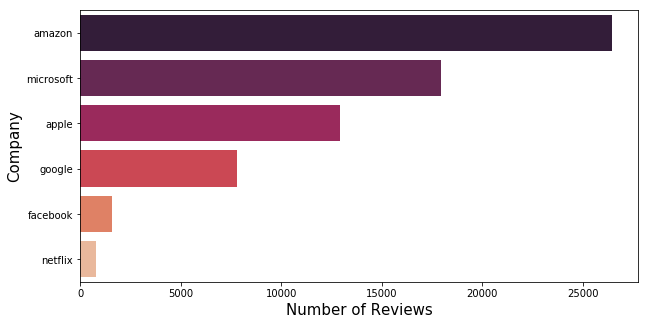

In [10]:
plt.figure(1 , figsize = (10 , 5))
sns.countplot(y = 'company' , data = df , palette = 'rocket' , 
              order = df['company'].value_counts().index)
plt.ylabel('Company', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=15)
plt.show()

<h3>Which company has highest average rating stars in various rating criterias? </h3>

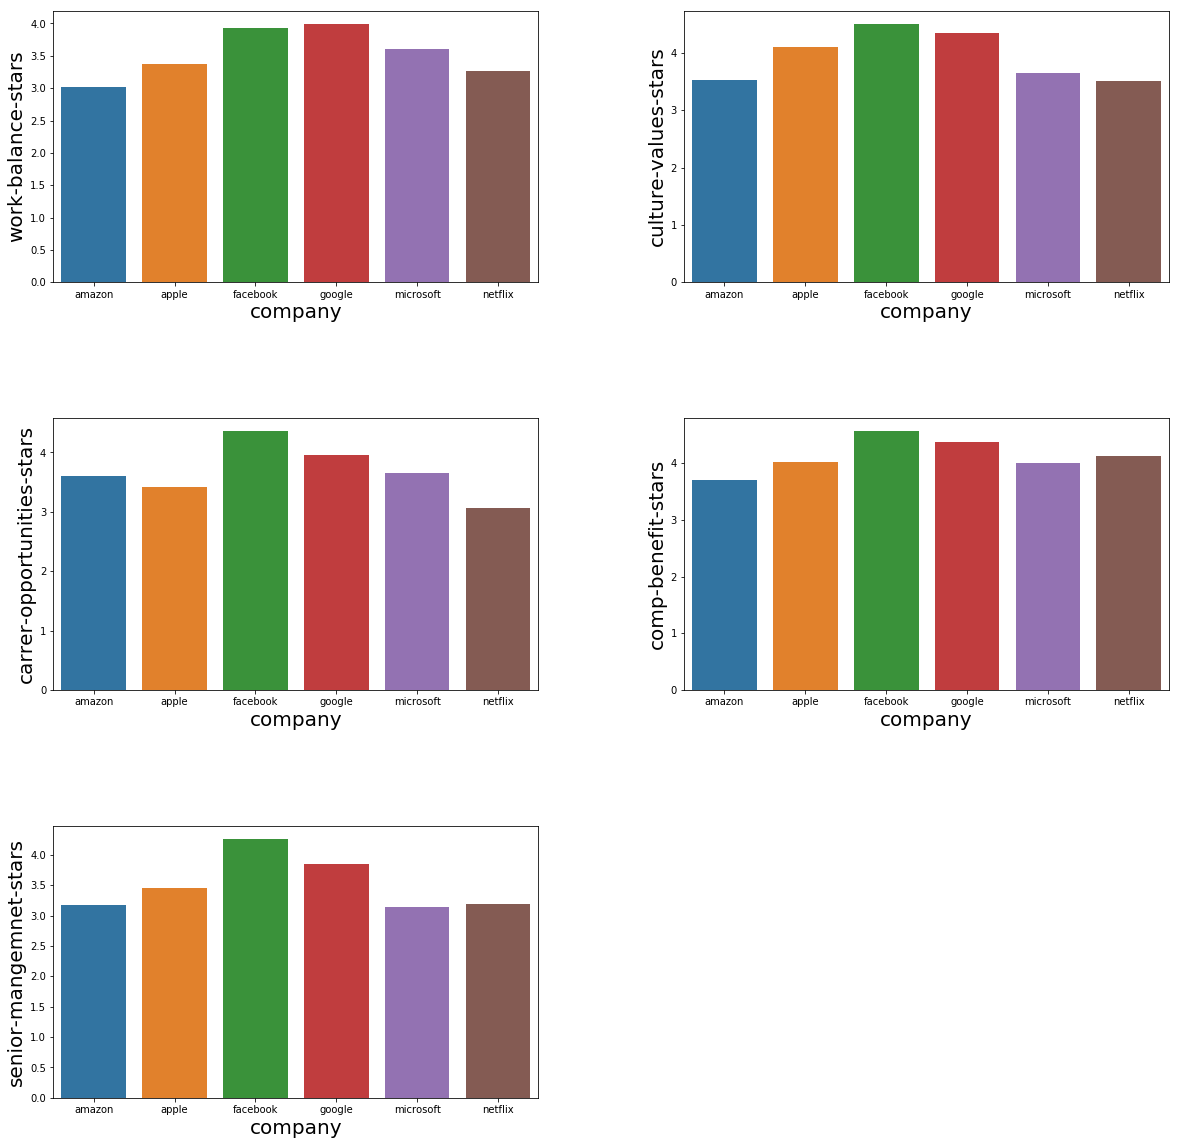

In [11]:
plt.figure(figsize = (20 , 20))
sub = 0 
parameter = list(df_avg.columns.values)
parameter = parameter[1:]
for i in parameter:
    sub += 1
    plt.subplot(3 , 2 , sub )
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.barplot(x = 'company' ,y= df_avg[i], data = df_avg)
    plt.ylabel(i, fontsize=20)
    plt.xlabel('company', fontsize=20)
plt.show()

<h3>How are the Overall-Ratings distributed company-wise ?</h3>

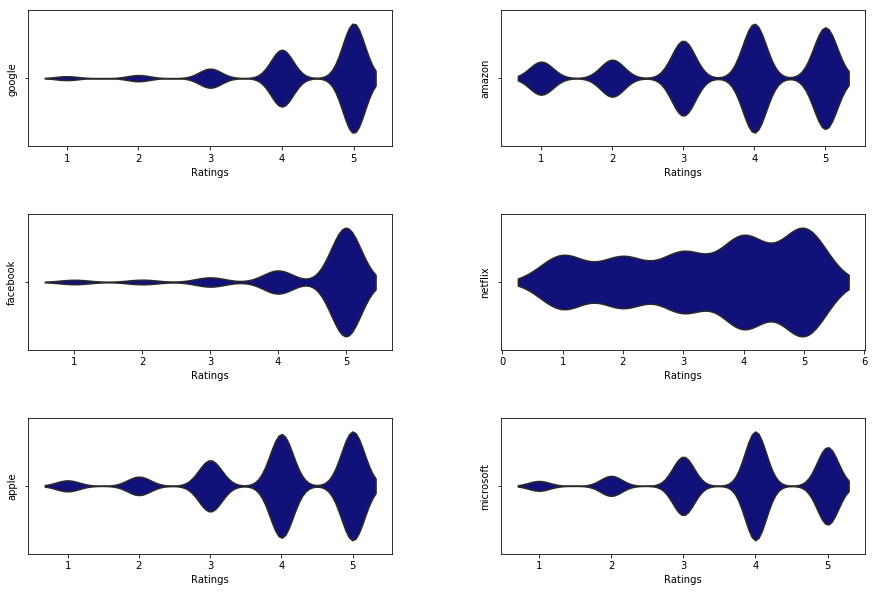

In [12]:
plt.figure(figsize = (15 , 10))
sub = 0 
for company in df['company'].unique():
    sub += 1
    plt.subplot(3 , 2 , sub )
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.violinplot(x = 'overall-ratings' , data = df.where(df['company'] == company),inner=None,color = 'darkblue')
    plt.xlabel('Ratings')
    plt.ylabel(company)
plt.show()

<h3> What factors are people considering the most while giving ratings?</h3>

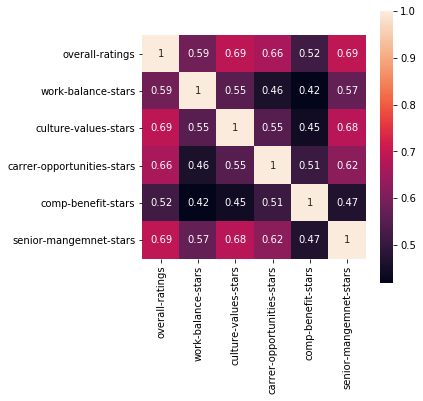

In [13]:
df_heat= df
del df_heat['helpful-count']
plt.figure(figsize = (5,5))
sns.heatmap(df_heat.corr(), square = True, linecolor = 'red', annot = True)

# Modelling
# NLP Model

In [14]:
df=df[['summary','overall-ratings']]
df.head()

,summary,overall-ratings
1,Best Company to work for,5
2,"Moving at the speed of light, burn out is inev...",4
3,Great balance between big-company security and...,5
4,The best place I've worked and also the most d...,5
5,"Unique, one of a kind dream job",5


In [15]:
df=df.dropna()
df['labels'] = np.where(df['overall-ratings'] > 2, 1, 0)
df.head()

,summary,overall-ratings,labels
1,Best Company to work for,5,1
2,"Moving at the speed of light, burn out is inev...",4,1
3,Great balance between big-company security and...,5,1
4,The best place I've worked and also the most d...,5,1
5,"Unique, one of a kind dream job",5,1


In [16]:
stop = set(stopwords.words('english'))

In [17]:
def clean_file(file):
    punctuation = string.punctuation
    punc_replace = ''.join([' ' for s in punctuation])
    file_link_clean = re.sub(r'http\S+', '', file)
    file_clean_and = re.sub(r'&\S+', '', file_link_clean)
    file_clean_at = re.sub(r'@\S+', '', file_clean_and)
    file_clean = file_clean_at.replace('-', ' ')
    file_alphas = re.sub(r'\W +', ' ', file_clean)
    trans_table = str.maketrans(punctuation, punc_replace)
    file_clean = ' '.join([word.translate(trans_table) for word in file_alphas.split(' ')])
    file_clean = file_clean.split(' ')
    p = re.compile(r'\s*\b(?=[a-z\d]*([a-z\d])\1{3}|\d+\b)[a-z\d]+', re.IGNORECASE)
    file_clean = ([p.sub("", x).strip() for x in file_clean])
    file_clean = [word.lower() for word in file_clean if len(word) > 2]
    file_clean = ([i for i in file_clean if i not in stop])
    file_clean = ([p.sub("", x).strip() for x in file_clean])
    return file_clean

In [18]:
review_clean = [clean_file(doc) for doc in df['summary']]
sentences = [' '.join(r) for r in review_clean]

In [19]:
df['clean']=sentences
df.head()

,summary,overall-ratings,labels,clean
1,Best Company to work for,5,1,best company work
2,"Moving at the speed of light, burn out is inev...",4,1,moving speed light burn inevitable
3,Great balance between big-company security and...,5,1,great balance big company security fun fast mo...
4,The best place I've worked and also the most d...,5,1,best place worked also demanding
5,"Unique, one of a kind dream job",5,1,unique one kind dream job


In [20]:
from sklearn.model_selection import train_test_split

X = df.clean
y = df.labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)

X_train_vect=X_train_vect.toarray()

In [22]:
counts = df.labels.value_counts()
print(counts)

1    58241
0     9155
Name: labels, dtype: int64


# Naive Bayes Classification

In [3]:
#sm = SMOTE(random_state=12)
#X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
nb.score(X_train_res, y_train_res)
X_test_vect = vect.transform(X_test)
y_pred_nb = nb.predict(X_test_vect)
y_pred_nb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

NameError: name 'SMOTE' is not defined

# Random Forest Classifier

In [24]:
rf = RandomForestClassifier(random_state=12)
rf.fit(X_train_res, y_train_res)
rf.score(X_train_res, y_train_res)

X_test_vect = vect.transform(X_test)

y_pred_rf = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
preds_rf = rf.predict(X_test_vect)
print("\nRandomForest Accuracy:",metrics.accuracy_score(y_test, preds_rf))

#Computing the error.
print("Mean Absoulte Error:", mean_absolute_error(preds_rf, y_test))

#Computing classification Report
print("\nClassification Report:\n", classification_report(y_test, preds_rf))

#Plotting confusion matrix
print("Confusion Matrix:")
df = pd.DataFrame(
    confusion_matrix(y_test, preds_rf),
    index = [['actual', 'actual'], ['0','1']],
    columns = [['predicted', 'predicted'], ['0', '1']])
print(df)

Accuracy: 70.62%

F1 Score: 80.86

Confusion Matrix:
 [[1154  686]
 [3275 8365]]

RandomForest Accuracy: 0.7061572700296735
Mean Absoulte Error: 0.2938427299703264

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.63      0.37      1840
           1       0.92      0.72      0.81     11640

   micro avg       0.71      0.71      0.71     13480
   macro avg       0.59      0.67      0.59     13480
weighted avg       0.83      0.71      0.75     13480

Confusion Matrix:
         predicted      
                 0     1
actual 0      1154   686
       1      3275  8365


# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 12)
lr.fit(X_train_res, y_train_res)
ypred=lr.score(X_train_res, y_train_res)
ypred
X_test_vect = vect.transform(X_test)
y_pred_lr = lr.predict(X_test_vect)
y_pred_lr
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lr) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_lr) * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Accuracy: 73.06%

F1 Score: 82.72

Confusion Matrix:
 [[1155  685]
 [2947 8693]]


# Word Cloud
<h3>Company Pros</h3>

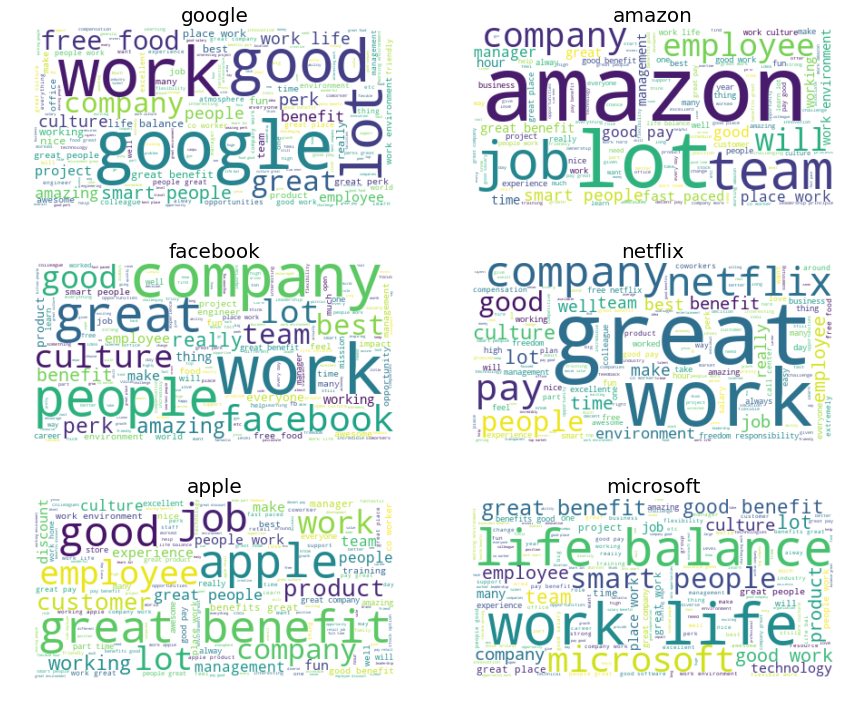

In [26]:
plt.figure(figsize = (15,12))
sub = 0 
for company in df_word['company'].unique():
    sub += 1
    plt.subplot(3 , 2 , sub )
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
    wordc = df_word.company.str.contains(company)
    df_word_wordc = df_word[wordc]
    pros = df_word_wordc['pros'] 
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    filtered_wds = [word for word in pros if not word in useless_words]
    stemmer = PorterStemmer()
    filtered_words = [stemmer.stem(word) for word in filtered_wds]
    cloudstr = ' '.join(filtered_words)

    #generate the cloud
    wordcloud = WordCloud(background_color="white").generate(cloudstr)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(company,fontsize=20)
    plt.axis("off")

plt.show()


<h3>Company Cons</h3>

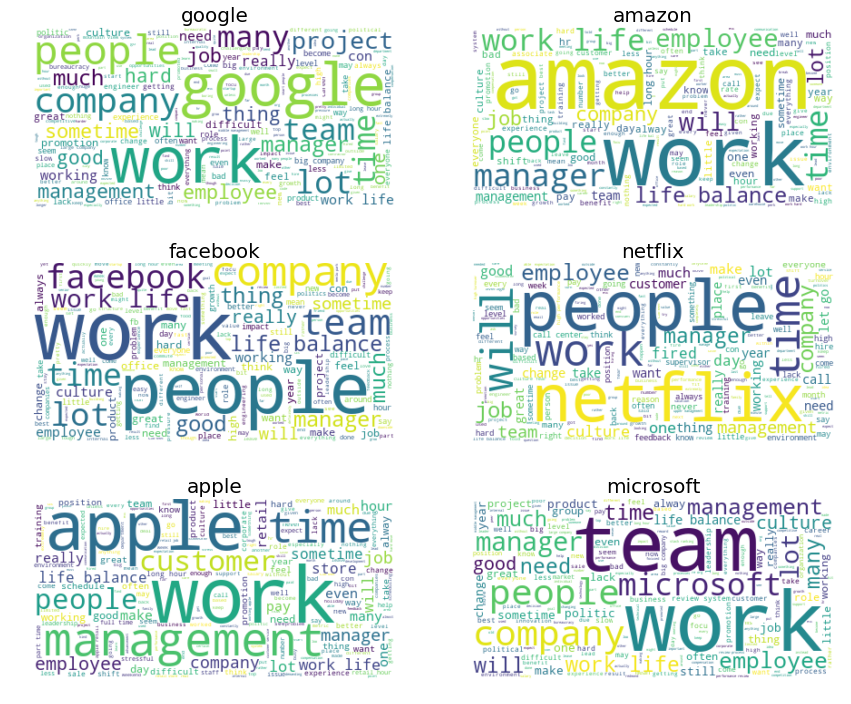

In [27]:
plt.figure(figsize = (15,12))
sub = 0 
for company in df_word['company'].unique():
    sub += 1
    plt.subplot(3 , 2 , sub )
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.1)
    wordc = df_word.company.str.contains(company)
    df_word_wordc = df_word[wordc]
    cons = df_word_wordc['cons'] 
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    filtered_wds = [word for word in cons if not word in useless_words]
    stemmer = PorterStemmer()
    filtered_words = [stemmer.stem(str(word)) for word in filtered_wds]
    cloudstr = ' '.join(filtered_words)
        
    #generate the cloud
    wordcloud = WordCloud(background_color="white").generate(cloudstr)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(company,fontsize=20)
    plt.axis("off")
    
plt.show()
